In [3]:
## imports
import numpy as np
from matplotlib import pyplot as plt
from struct import unpack
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import modeling
import time
import numpy.matlib
%matplotlib widget

In [4]:
# Spectrometer_221125
filename = "C:/Users/jakub/Documents/LinoSpad2/data/Spectrometer_221125/Ar_lines_fiber.dat"
filename = "C:/Users/jakub/Documents/LinoSpad2/data/Spectrometer_221207/Spectrum_Ar_512"

In [5]:
# Read data file 
lines_of_data = 512

st = time.time()

rawFile = np.fromfile(filename, dtype=np.uint32) # read data 
data = ((rawFile & 0xFFFFFFF).astype(np.longlong))*17.857   # Multiply with the lowes bin   
data[np.where(rawFile < 0x80000000)] = -1 # Mask not valid data 
nmrCycles = int(len(data) / lines_of_data / 256)  # number of cycles,
data_matrix = data.reshape((lines_of_data,nmrCycles*256), order='F').reshape((lines_of_data, 256,-1),order='F').transpose((0,2,1)).reshape((-1, 256),order='F').transpose() # reshape the matrix
    
et = time.time()
print('Execution time:', et - st, 'seconds')


Execution time: 6.130141973495483 seconds


Positions of pixels over 25k: [87, 88, 114, 115, 118, 119, 159, 160, 165, 166, 234, 235]
1251.0


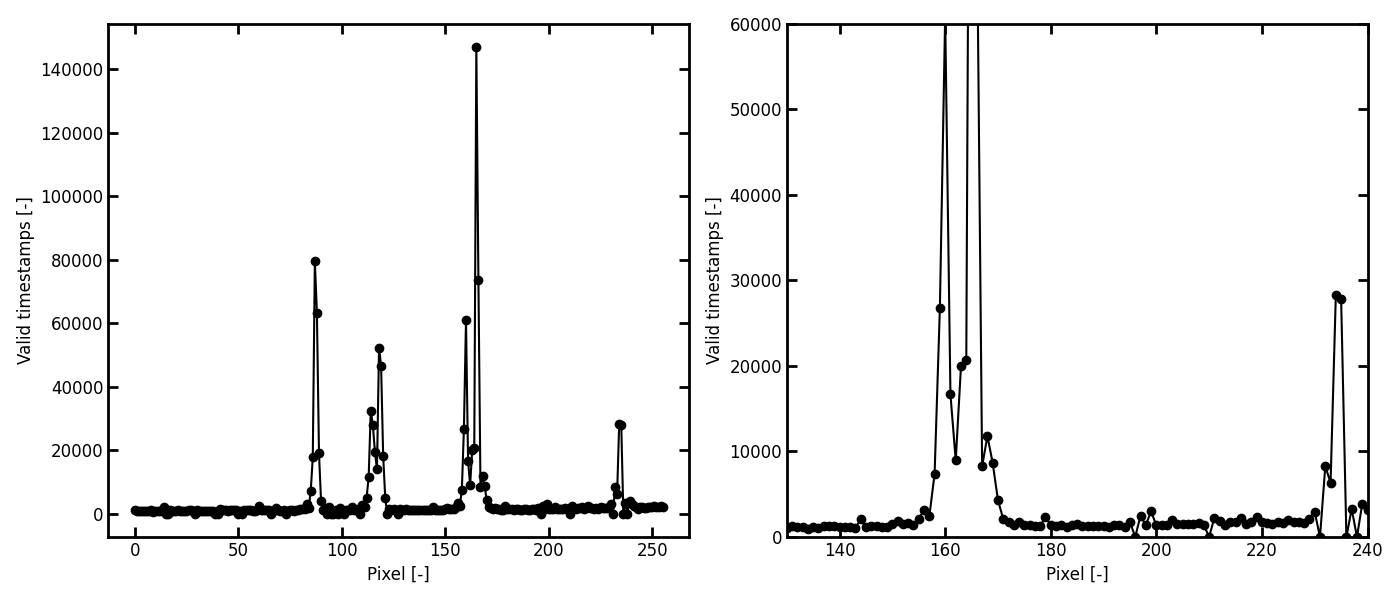

In [22]:
## Compute histogram of valid time stamps per pixel
# Masking out pixels 15 and 93

validPerPixel = np.zeros(256)
maskValidPixels = np.ones(256)

# Here put all pixels you want to mask

mask = [15,50,52,66,93,98,109,122,127,210,231,236]
mask = [15,16,29,39,40,50,52,66,73,93,95,96,98,101,109,122,127,196,210,231,236,238]
maskValidPixels[mask] = 0
# maskValidPixels[15] = 0
# maskValidPixels[93] = 0

for j in range(len(data_matrix)):
    validPerPixel[j] = len(np.where(data_matrix[j] > 0)[0])

timestampHist = maskValidPixels*validPerPixel

fig, ax = plt.subplots(1,2)

plt.rcParams.update({"font.size": 12})
x = np.arange(0, 256, 1)

plt.xlabel("Pixel [-]")
plt.ylabel("Valid timestamps [-]")
plt.box(bool(1))
plt.grid(False)
plt.subplots_adjust(left=0.15)
fig.set_size_inches(14, 6)

for i in range(2):
    ax[i].tick_params(which="both", width=2, direction="in")
    ax[i].tick_params(which="major", length=7, direction="in")
    ax[i].tick_params(which="minor", length=4, direction="in")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")
    ax[i].set_xlabel("Pixel [-]")
    ax[i].set_ylabel("Valid timestamps [-]")

for axis in ["top", "bottom", "left", "right"]:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)
    
ax[0].plot(x, timestampHist,'-ok');
ax[1].plot(x, timestampHist,'-ok');

# Set the zoom limits of right plot
ax[1].set_xlim(130, 240)
ax[1].set_ylim(0, 60000)

fig.tight_layout(pad=1.0)

print("Positions of pixels over 25k: " + str([i for i,v in enumerate(timestampHist) if v > 25000]))
print(timestampHist[0])

56669.806296846844
The sum under the peak is 407573.0


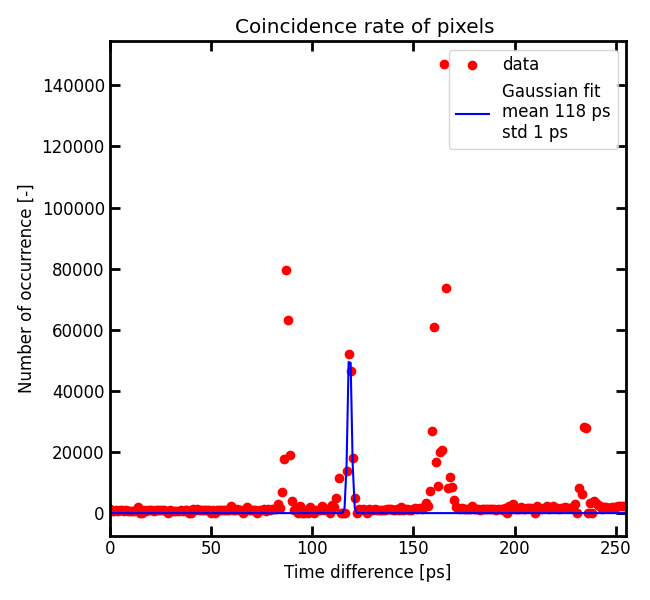

In [24]:
## Fit coincidence rate with gaussian 

timestampHist = timestampHist
timestampHist[114]=0
timestampHist[115]=0
timestampHist[116]=0
x = np.arange(0, 256, 1)

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

n_max = np.argmax(timestampHist)
sigma = 0.5

parameters, covariance = curve_fit(gauss, x, timestampHist,p0=[max(timestampHist), 118, sigma])

fit_y = gauss(x, parameters[0], parameters[1], parameters[2])
print(parameters[0])
## Plots
fig, ax = plt.subplots(1, 1, figsize=(6.5, 6), tight_layout=True)
ax.tick_params(which="both", width=2, direction="in")
ax.tick_params(which="major", length=7, direction="in")
ax.tick_params(which="minor", length=4, direction="in")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Time difference [ps]")
ax.set_ylabel("Number of occurrence [-]")
ax.set_title("Coincidence rate of pixels ")
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)
plt.xlim(0, 255)
ax.plot(x, timestampHist, 'ro', label='data')
ax.plot(x, fit_y, 'b-', label="Gaussian fit \nmean {} ps\nstd {} ps".format(int(np.round(parameters[1])),int(np.round(parameters[2]))))
ax.legend()

print("The sum under the peak is " + str(np.sum(timestampHist[n_max-6:n_max+6])))


 
0.2154 x + 776


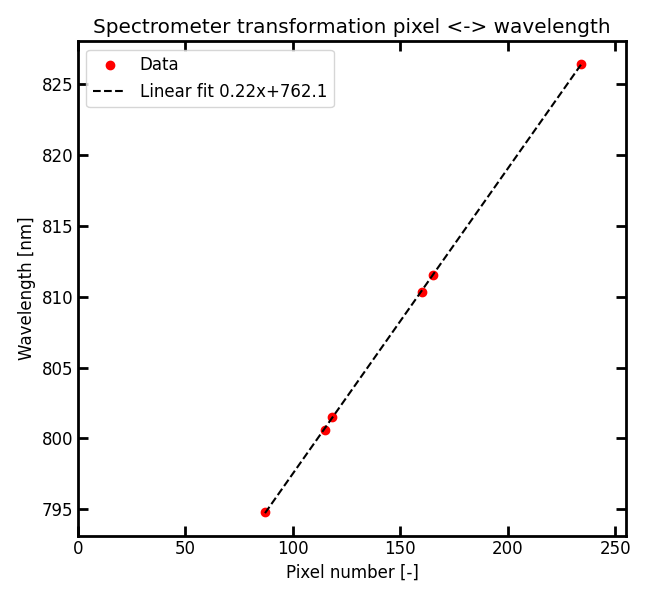

In [25]:

amplitude = [85202,31114,56669,60784,157419,35887]
x = [87, 115,118, 160,165, 234]
waveL= [794.82,800.62,801.48,810.32,811.53,826.45]
std = [1.0, 1.0, 1.0,1.0,1.0,1.0]


## Plots
fig, ax = plt.subplots(1, 1, figsize=(6.5, 6), tight_layout=True)
ax.tick_params(which="both", width=2, direction="in")
ax.tick_params(which="major", length=7, direction="in")
ax.tick_params(which="minor", length=4, direction="in")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Pixel number [-]")
ax.set_ylabel("Wavelength [nm]")
ax.set_title("Spectrometer transformation pixel <-> wavelength")
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)
plt.xlim(0, 255)

coef = np.polyfit(x, waveL, 1)
poly1d_fn = np.poly1d(coef) 

plt.plot(x, waveL, 'ro', x, poly1d_fn(x), '--k')

# ax.plot(x, fit_y, 'b-', label="Gaussian fit \nmean {} ps\nstd {} ps".format(int(np.round(parameters[1])),int(np.round(parameters[2]))))
ax.legend(["Data","Linear fit 0.22x+762.1"])
print(poly1d_fn)

Positions of pixels over 25k: [87, 88, 114, 115, 118, 119, 159, 160, 165, 166, 234, 235]
1251.0


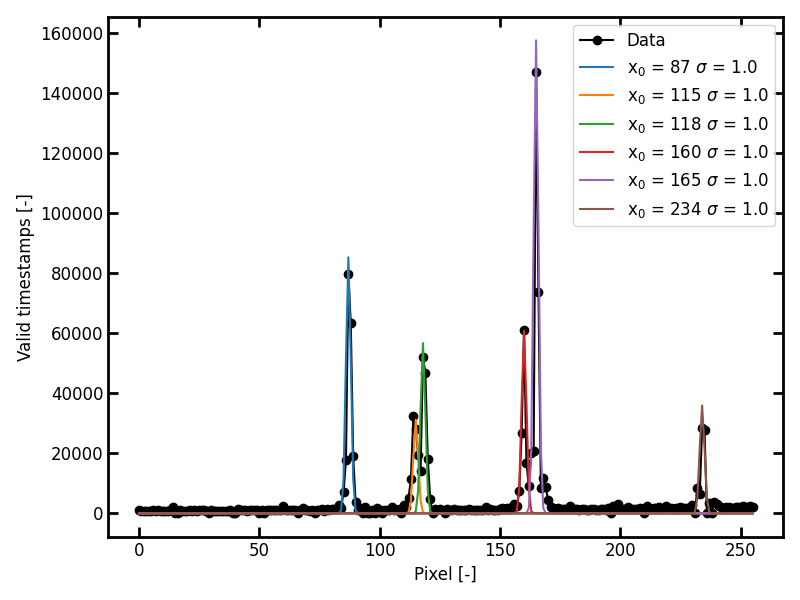

In [32]:

amplitude = [85202,31114,56669,60784,157419,35887]
pixel = [87, 115,118, 160,165, 234]
std = [1.0, 1.0, 1.0,1.0,1.0,1.0]


validPerPixel = np.zeros(256)
maskValidPixels = np.ones(256)

# Here put all pixels you want to mask

mask = [15,50,52,66,93,98,109,122,127,210,231,236]
mask = [15,16,29,39,40,50,52,66,73,93,95,96,98,101,109,122,127,196,210,231,236,238]
maskValidPixels[mask] = 0
# maskValidPixels[15] = 0
# maskValidPixels[93] = 0

for j in range(len(data_matrix)):
    validPerPixel[j] = len(np.where(data_matrix[j] > 0)[0])

timestampHist = maskValidPixels*validPerPixel

fig, ax = plt.subplots(1,1)
plt.rcParams.update({"font.size": 12})
x = np.arange(0, 256, 1)

plt.xlabel("Pixel [-]")
plt.ylabel("Valid timestamps [-]")
plt.box(bool(1))
plt.grid(False)
plt.subplots_adjust(left=0.15)
fig.set_size_inches(8, 6)

ax.tick_params(which="both", width=2, direction="in")
ax.tick_params(which="major", length=7, direction="in")
ax.tick_params(which="minor", length=4, direction="in")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Pixel [-]")
ax.set_ylabel("Valid timestamps [-]")

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)

ax.plot(x, timestampHist,'-ok');
for ind in range(len(amplitude)):
    ax.plot(x, gauss(x, amplitude[ind], pixel[ind], std[ind]));



fig.tight_layout(pad=1.0)

print("Positions of pixels over 25k: " + str([i for i,v in enumerate(timestampHist) if v > 25000]))
print(timestampHist[0])
ax.legend(["Data","x$_0$ = " + str(round(pixel[0],2)) + " $\sigma$ = " + str(round(std[0],2)),
           "x$_0$ = " + str(round(pixel[1],2)) + " $\sigma$ = " + str(round(std[1],2)),
           "x$_0$ = " + str(round(pixel[2],2)) + " $\sigma$ = " + str(round(std[2],2)),
           "x$_0$ = " + str(round(pixel[3],2)) + " $\sigma$ = " + str(round(std[3],2)),
           "x$_0$ = " + str(round(pixel[4],2)) + " $\sigma$ = " + str(round(std[4],2)),
           "x$_0$ = " + str(round(pixel[5],2)) + " $\sigma$ = " + str(round(std[5],2))])


Positions of pixels over 25k: [87, 88, 114, 115, 118, 119, 159, 160, 165, 166, 234, 235]
1251.0


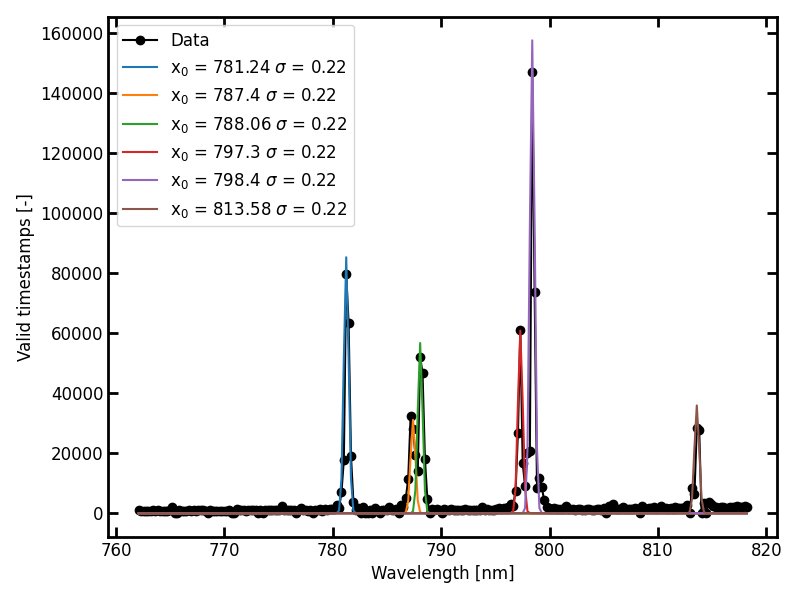

In [31]:
amplitude = [85202,31114,56669,60784,157419,35887]
pixel = np.array([87.0, 115.0,118.0, 160.0,165.0, 234.0])*0.22+762.1
std = np.array([1.0, 1.0, 1.0,1.0,1.0,1.0])*0.22

validPerPixel = np.zeros(256)
maskValidPixels = np.ones(256)

# Here put all pixels you want to mask

mask = [15,50,52,66,93,98,109,122,127,210,231,236]
mask = [15,16,29,39,40,50,52,66,73,93,95,96,98,101,109,122,127,196,210,231,236,238]
maskValidPixels[mask] = 0
# maskValidPixels[15] = 0
# maskValidPixels[93] = 0

for j in range(len(data_matrix)):
    validPerPixel[j] = len(np.where(data_matrix[j] > 0)[0])

timestampHist = maskValidPixels*validPerPixel

fig, ax = plt.subplots(1,1)
plt.rcParams.update({"font.size": 12})
x = np.arange(0, 256, 1)*0.22+762.1

plt.xlabel("Pixel [-]")
plt.ylabel("Valid timestamps [-]")
plt.box(bool(1))
plt.grid(False)
plt.subplots_adjust(left=0.15)
fig.set_size_inches(8, 6)

ax.tick_params(which="both", width=2, direction="in")
ax.tick_params(which="major", length=7, direction="in")
ax.tick_params(which="minor", length=4, direction="in")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Valid timestamps [-]")

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)

ax.plot(x, timestampHist,'-ok');
for ind in range(len(amplitude)):
    ax.plot(x, gauss(x, amplitude[ind], pixel[ind], std[ind]));



fig.tight_layout(pad=1.0)

print("Positions of pixels over 25k: " + str([i for i,v in enumerate(timestampHist) if v > 25000]))
print(timestampHist[0])
ax.legend(["Data","x$_0$ = " + str(round(pixel[0],2)) + " $\sigma$ = " + str(round(std[0],2)),
           "x$_0$ = " + str(round(pixel[1],2)) + " $\sigma$ = " + str(round(std[1],2)),
           "x$_0$ = " + str(round(pixel[2],2)) + " $\sigma$ = " + str(round(std[2],2)),
           "x$_0$ = " + str(round(pixel[3],2)) + " $\sigma$ = " + str(round(std[3],2)),
           "x$_0$ = " + str(round(pixel[4],2)) + " $\sigma$ = " + str(round(std[4],2)),
           "x$_0$ = " + str(round(pixel[5],2)) + " $\sigma$ = " + str(round(std[5],2))])

